In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/MyDrive/NIH")
os.getcwd()

'/content/drive/MyDrive/NIH'

PREPROCESSING


In [ ]:
!pip install tensorflow
!pip install tensorflow_addons

In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import itertools
import time

import seaborn as sns

import tensorflow as tf
import tensorflow_addons as tfa

import matplotlib.pyplot as plt

from tensorflow.keras import backend as K

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LayerNormalization, Input, LSTM, GRU, TimeDistributed
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, Dense, Softmax, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

from pandas import DataFrame
from typing import List
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# Read the dataframe
df = pd.read_csv('Data_Entry_2017.csv')

# Rename the columns
df = df.rename(columns={
    "OriginalImagePixelSpacing[x": "OriginalImagePixelSpacingX",
    "y]": "OriginalImagePixelSpacingY",
    "OriginalImage[Width": "OriginalImageWidth",
    "Height]": "OriginalImageHeight"
})

### Format the label by a one hot encoding

# Get all the label
unique_labels = set(itertools.chain.from_iterable(df["Finding Labels"].apply(lambda x : x.split('|')).values))
unique_lab = list(unique_labels)
type(unique_lab)

# Initialize a empty matrix
one_hot_labels = pd.DataFrame(0.0, index=np.arange(len(df)), columns=unique_lab)

# For each row, we get the associated labels and set a 1 to the new corresponding column label
for index, row in df.iterrows():
    labels = row["Finding Labels"].split('|')
    for label in labels:
        one_hot_labels.iloc[index][label] = 1.0

# Then, we concatane this new dataframe to our original data
df = pd.concat([df, one_hot_labels], axis=1)

df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacingX,...,Fibrosis,Cardiomegaly,Atelectasis,No Finding,Consolidation,Hernia,Pneumonia,Edema,Effusion,Nodule
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
df_train = df
print("Size of training set :", len(df_train))

Size of training set : 15000


In [ ]:
df_train.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacingX,...,Fibrosis,Cardiomegaly,Atelectasis,No Finding,Consolidation,Hernia,Pneumonia,Edema,Effusion,Nodule
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
DATA_DIR = "NIH_chest"
NB_LABELS = len(unique_labels)
print("labels",len(unique_labels))
BATCH_SIZE = 32

X_train, X_valid = train_test_split(df_train, test_size = 0.2, random_state = 42)
X_train, X_test = train_test_split(X_train, test_size = 0.125, random_state = 42)

print(len(X_train),len(X_valid),len(X_test))


labels 15
10500 3000 1500


In [ ]:
X_train

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacingX,...,Fibrosis,Cardiomegaly,Atelectasis,No Finding,Consolidation,Hernia,Pneumonia,Edema,Effusion,Nodule
1248,00000318_006.png,No Finding,6,318,57,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10934,00002843_005.png,No Finding,5,2843,56,F,PA,2500,2048,0.171,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1963,00000505_001.png,No Finding,1,505,74,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
14673,00003822_001.png,No Finding,1,3822,35,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
12809,00003362_004.png,Effusion|Infiltration,4,3362,62,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9274,00002418_000.png,Cardiomegaly,0,2418,8,F,PA,2048,2500,0.171,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13089,00003407_001.png,No Finding,1,3407,36,F,PA,2986,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8719,00002300_027.png,Infiltration,27,2300,81,F,AP,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12181,00003175_001.png,No Finding,1,3175,45,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.columns.tolist()

['Image Index',
 'Finding Labels',
 'Follow-up #',
 'Patient ID',
 'Patient Age',
 'Patient Gender',
 'View Position',
 'OriginalImageWidth',
 'OriginalImageHeight',
 'OriginalImagePixelSpacingX',
 'OriginalImagePixelSpacingY',
 'Emphysema',
 'Infiltration',
 'Mass',
 'Pneumothorax',
 'Pleural_Thickening',
 'Fibrosis',
 'Cardiomegaly',
 'Atelectasis',
 'No Finding',
 'Consolidation',
 'Hernia',
 'Pneumonia',
 'Edema',
 'Effusion',
 'Nodule']

IMPORTING PACKAGES AND INITIALZING DATA GENERATOR

In [ ]:
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import os

# Define image size and batch size
img_width, img_height = 150, 224  # InceptionV3 input size
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1.0 / 255.0,)  # Rescale pixel values
validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

CREATING DATASET FOR MODEL TRAINING

In [ ]:
# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    X_train,
    directory='./NIH_chest',
    x_col='Image Index',
    y_col=['Edema','Infiltration','Hernia','Pneumonia','Atelectasis','Cardiomegaly','Emphysema','Pleural_Thickening','Mass','Consolidation','Nodule','Effusion','No Finding','Fibrosis','Pneumothorax'],
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='raw'
)

validation_generator = validation_datagen.flow_from_dataframe(
    X_valid,
    directory='./NIH_chest',
    x_col='Image Index',
    y_col=['Edema','Infiltration','Hernia','Pneumonia','Atelectasis','Cardiomegaly','Emphysema','Pleural_Thickening','Mass','Consolidation','Nodule','Effusion','No Finding','Fibrosis','Pneumothorax'],
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='raw'
)

test_generator = test_datagen.flow_from_dataframe(
    X_test,
    directory='./NIH_chest',
    x_col='Image Index',
    y_col=['Edema','Infiltration','Hernia','Pneumonia','Atelectasis','Cardiomegaly','Emphysema','Pleural_Thickening','Mass','Consolidation','Nodule','Effusion','No Finding','Fibrosis','Pneumothorax'],
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='raw'
)

Found 10500 validated image filenames.
Found 3000 validated image filenames.
Found 1499 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="Image Index". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
x, y = next(iter(train_generator))
print("Training data shape:", x.shape, y.shape)
x_val, y_val = next(iter(validation_generator))
print("Validation data shape:", x_val.shape, y_val.shape)

Training data shape: (32, 150, 224, 3) (32, 15)
Validation data shape: (32, 150, 224, 3) (32, 15)


INITILAIZING INCPETION V3 MODEL

In [ ]:
# Load the InceptionV3 model
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 224, 3))

for layer in base_model_inception.layers:
    layer.trainable = False

# Add custom top layers for classification
x_inception = base_model_inception.output
x_inception = GlobalAveragePooling2D()(x_inception)
x_inception = Dense(1024, activation='relu')(x_inception)
x_inception = Dense(512, activation='relu')(x_inception)
predictions_inception = Dense(15, activation='sigmoid')(x_inception)

# Create the InceptionV3 model for fine-tuning
model_inception = Model(inputs=base_model_inception.input, outputs=predictions_inception)

model_inception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 111, 32)          864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 111, 32)          96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 111, 32)          0         ['batch_normalization[0][0

INCEPTION V3 MODEL FITTING

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoints = ModelCheckpoint("./models/inceptionv3.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoints]

model_inception.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                        loss='binary_crossentropy',
                        metrics=['accuracy',
                                 'Precision','Recall','AUC'])


history = model_inception.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size,
                    epochs=5,callbacks= callbacks_list)

Epoch 1/5
328/328 [==============================] - ETA: 0s - loss: 0.2069 - accuracy: 0.5667 - precision: 0.6241 - recall: 0.3610 - auc: 0.8410
Epoch 1: val_accuracy improved from -inf to 0.58535, saving model to ./models/inceptionv3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


328/328 [==============================] - 347s 980ms/step - loss: 0.2069 - accuracy: 0.5667 - precision: 0.6241 - recall: 0.3610 - auc: 0.8410 - val_loss: 0.1904 - val_accuracy: 0.5853 - val_precision: 0.6475 - val_recall: 0.4255 - val_auc: 0.8711
Epoch 2/5
328/328 [==============================] - ETA: 0s - loss: 0.1917 - accuracy: 0.5727 - precision: 0.6674 - recall: 0.3702 - auc: 0.8672
Epoch 2: val_accuracy did not improve from 0.58535
328/328 [==============================] - 301s 919ms/step - loss: 0.1917 - accuracy: 0.5727 - precision: 0.6674 - recall: 0.3702 - auc: 0.8672 - val_loss: 0.1889 - val_accuracy: 0.5827 - val_precision: 0.6517 - val_recall: 0.4169 - val_auc: 0.8741
Epoch 3/5
328/328 [==============================] - ETA: 0s - loss: 0.1890 - accuracy: 0.5755 - precision: 0.6732 - recall: 0.3734 - auc: 0.8729
Epoch 3: val_accuracy did not improve from 0.58535
328/328 [==============================] - 314s 959ms/step - loss: 0.1890 - accuracy: 0.5755 - precision: 0.

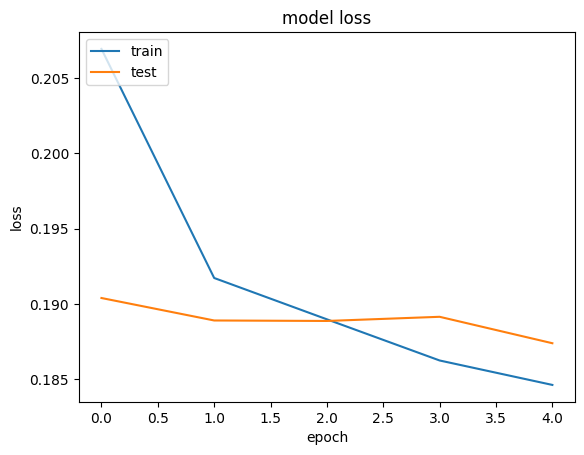

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

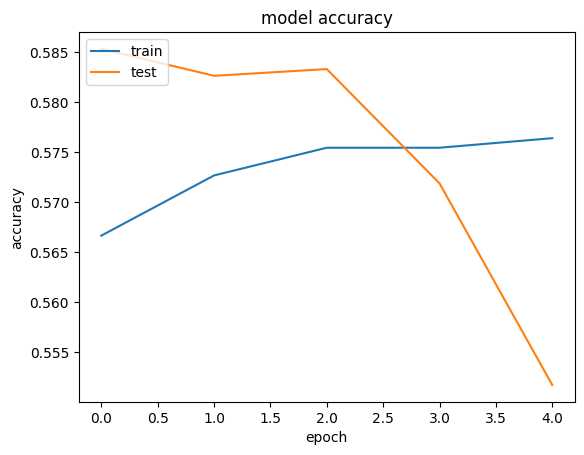

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

INTIALIZING RESNET 50 MODEL

In [ ]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 224, 3))

for layer in base_model_resnet.layers:
    layer.trainable = False

x_resnet = base_model_resnet.output
x_resnet = GlobalAveragePooling2D()(x_resnet)
x_resnet = Dense(1024, activation='relu')(x_resnet)
x_resnet = Dense(512, activation='relu')(x_resnet)
predictions_resnet = Dense(15, activation='sigmoid')(x_resnet)


model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions_resnet)
model_resnet.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 150, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 112, 64)          9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 112, 64)          256       ['conv1_conv[0][0]']          
 on)                       

RESNTET 50 MODEL FITTING

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoints = ModelCheckpoint("./models/res50.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoints]

# Compile the model
model_resnet.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                      loss='binary_crossentropy',
                      metrics=['accuracy','Precision', 'Recall','AUC'])

# Train the ResNet50 model
his = model_resnet.fit(train_generator,
                steps_per_epoch=train_generator.samples // batch_size,
                validation_data=validation_generator,
                validation_steps=validation_generator.samples // batch_size,
                epochs=5,callbacks = callbacks_list)

Epoch 1/5
328/328 [==============================] - ETA: 0s - loss: 0.2040 - accuracy: 0.5807 - precision: 0.5816 - recall: 0.4404 - auc: 0.8344
Epoch 1: val_accuracy improved from -inf to 0.58266, saving model to ./models/res50.h5
328/328 [==============================] - 325s 971ms/step - loss: 0.2040 - accuracy: 0.5807 - precision: 0.5816 - recall: 0.4404 - auc: 0.8344 - val_loss: 0.2027 - val_accuracy: 0.5827 - val_precision: 0.5827 - val_recall: 0.4845 - val_auc: 0.8400
Epoch 2/5
328/328 [==============================] - ETA: 0s - loss: 0.2028 - accuracy: 0.5810 - precision: 0.5807 - recall: 0.4676 - auc: 0.8374
Epoch 2: val_accuracy did not improve from 0.58266
328/328 [==============================] - 310s 947ms/step - loss: 0.2028 - accuracy: 0.5810 - precision: 0.5807 - recall: 0.4676 - auc: 0.8374 - val_loss: 0.2027 - val_accuracy: 0.5827 - val_precision: 0.5827 - val_recall: 0.4841 - val_auc: 0.8408
Epoch 3/5
328/328 [==============================] - ETA: 0s - loss: 0.2

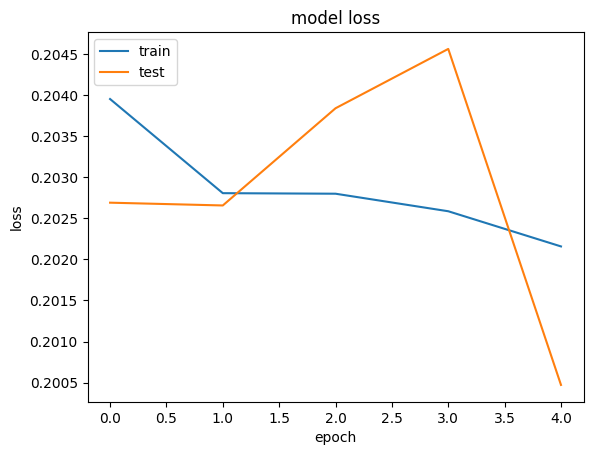

In [ ]:
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

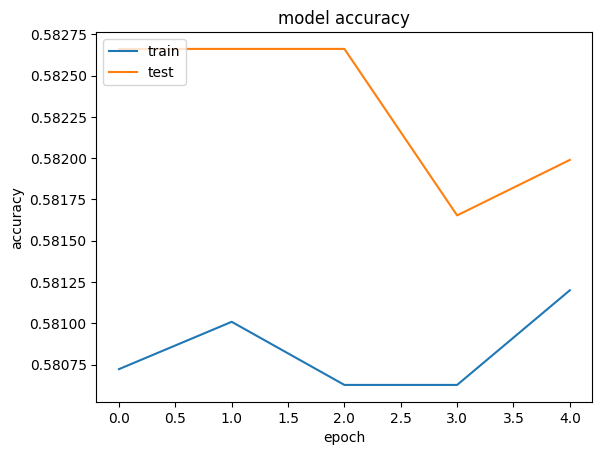

In [ ]:
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

EVALUATING AND INFERENCING

In [ ]:
from tensorflow import keras
model = keras.models.load_model("./models/inceptionv3.h5")

In [ ]:
class_indices = {class_name: i for i, class_name in enumerate(X_test.columns[11:])}
class_indices

{'Pneumonia': 0,
 'Hernia': 1,
 'No Finding': 2,
 'Pneumothorax': 3,
 'Nodule': 4,
 'Mass': 5,
 'Consolidation': 6,
 'Edema': 7,
 'Effusion': 8,
 'Infiltration': 9,
 'Emphysema': 10,
 'Cardiomegaly': 11,
 'Pleural_Thickening': 12,
 'Fibrosis': 13,
 'Atelectasis': 14}

In [ ]:
from sklearn.metrics import roc_auc_score,accuracy_score, classification_report
# Make predictions on the test set
predictions = model.predict(test_generator)

class_indices = {class_name: i for i, class_name in enumerate(X_test.columns[11:])}

# Convert predictions to binary values (0 or 1) based on a threshold (e.g., 0.5)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

# Compute AUC and accuracy for each label
per_label_aucs = []
per_label_accuracies = []
for class_name, i in class_indices.items():
    true_labels = test_generator.labels[:, i]

    # Check if there is variation in the true labels for the label
    if len(np.unique(true_labels)) > 1:
        predicted_probs = predictions[:, i]
        auc = roc_auc_score(true_labels, predicted_probs)
        accuracy = accuracy_score(true_labels, binary_predictions[:, i])

        per_label_aucs.append((class_name, auc))
        per_label_accuracies.append((class_name, accuracy))
    else:
        print(f"Skipping label {class_name} due to no variation in true labels.")

# Compute overall AUC and accuracy
overall_auc = roc_auc_score(test_generator.labels, predictions)
overall_accuracy = accuracy_score(test_generator.labels, binary_predictions)

# Report overall AUC and accuracy
print(f"\nOverall AUC: {overall_auc:.4f}")
print(f"Overall Accuracy: {overall_accuracy:.4f}")

# Report per-label AUCs
print("\nPer-Label AUCs:")
for class_name, auc in per_label_aucs:
    print(f"{class_name}: {auc:.4f}")

# Report per-label accuracies
print("\nPer-Label Accuracies:")
for class_name, accuracy in per_label_accuracies:
    print(f"{class_name}: {accuracy:.4f}")


47/47 [==============================] - 29s 608ms/step

Overall AUC: 0.5061
Overall Accuracy: 0.6037

Per-Label AUCs:
Pneumonia: 0.5307
Hernia: 0.4760
No Finding: 0.5544
Pneumothorax: 0.4624
Nodule: 0.4970
Mass: 0.4563
Consolidation: 0.4703
Edema: 0.6053
Effusion: 0.4581
Infiltration: 0.5481
Emphysema: 0.5451
Cardiomegaly: 0.5282
Pleural_Thickening: 0.4991
Fibrosis: 0.4570
Atelectasis: 0.5029

Per-Label Accuracies:
Pneumonia: 0.9873
Hernia: 0.8639
No Finding: 0.9953
Pneumothorax: 0.9873
Nodule: 0.9179
Mass: 0.9787
Consolidation: 0.9767
Edema: 0.9720
Effusion: 0.9660
Infiltration: 0.9600
Emphysema: 0.9546
Cardiomegaly: 0.9126
Pleural_Thickening: 0.6037
Fibrosis: 0.9713
Atelectasis: 0.9620


In [ ]:
from tensorflow import keras
model = keras.models.load_model("./models/res50.h5")

In [ ]:
from sklearn.metrics import roc_auc_score,accuracy_score, classification_report
# Make predictions on the test set
predictions = model.predict(test_generator)

class_indices = {class_name: i for i, class_name in enumerate(X_test.columns[11:])}

# Convert predictions to binary values (0 or 1) based on a threshold (e.g., 0.5)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

# Compute AUC and accuracy for each label
per_label_aucs = []
per_label_accuracies = []
for class_name, i in class_indices.items():
    true_labels = test_generator.labels[:, i]

    # Check if there is variation in the true labels for the label
    if len(np.unique(true_labels)) > 1:
        predicted_probs = predictions[:, i]
        auc = roc_auc_score(true_labels, predicted_probs)
        accuracy = accuracy_score(true_labels, binary_predictions[:, i])

        per_label_aucs.append((class_name, auc))
        per_label_accuracies.append((class_name, accuracy))
    else:
        print(f"Skipping label {class_name} due to no variation in true labels.")

# Compute overall AUC and accuracy
overall_auc = roc_auc_score(test_generator.labels, predictions)
overall_accuracy = accuracy_score(test_generator.labels, binary_predictions)

# Report overall AUC and accuracy
print(f"\nOverall AUC: {overall_auc:.4f}")
print(f"Overall Accuracy: {overall_accuracy:.4f}")

# Report per-label AUCs
print("\nPer-Label AUCs:")
for class_name, auc in per_label_aucs:
    print(f"{class_name}: {auc:.4f}")

# Report per-label accuracies
print("\nPer-Label Accuracies:")
for class_name, accuracy in per_label_accuracies:
    print(f"{class_name}: {accuracy:.4f}")


47/47 [==============================] - 29s 603ms/step

Overall AUC: 0.5121
Overall Accuracy: 0.6037

Per-Label AUCs:
Pneumonia: 0.4171
Hernia: 0.4494
No Finding: 0.6692
Pneumothorax: 0.5944
Nodule: 0.5002
Mass: 0.5205
Consolidation: 0.4941
Edema: 0.5608
Effusion: 0.4560
Infiltration: 0.4792
Emphysema: 0.5185
Cardiomegaly: 0.5054
Pleural_Thickening: 0.4912
Fibrosis: 0.5346
Atelectasis: 0.4903

Per-Label Accuracies:
Pneumonia: 0.9873
Hernia: 0.8639
No Finding: 0.9953
Pneumothorax: 0.9873
Nodule: 0.9179
Mass: 0.9787
Consolidation: 0.9767
Edema: 0.9720
Effusion: 0.9660
Infiltration: 0.9600
Emphysema: 0.9546
Cardiomegaly: 0.9126
Pleural_Thickening: 0.6037
Fibrosis: 0.9713
Atelectasis: 0.9620
